<h1>WFA with a magnetic field gradient</h1>

Let's extract $B_{LOS}$ from Stokes I and V spectra when the atmosphere has a vertical magnetic field gradient. 

In [24]:
# First some imports
import matplotlib.pyplot as plt
import rhanalyze
import numpy as np
from rhanalyze.rhatmos import input_atmos
import glob
from numpy.polynomial import polynomial as P

In [25]:
# and some styling
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


In [26]:
# Name of RH output directory with vertical magnetic field gradient
rhoutput = '/Users/rce/work/RH/rhf1d/run_Bgrad_expon'
rhoutput = '/Users/rce/work/RH/rhf1d/run_Bgrad_linear'
#rhoutput = '/Users/rce/work/RH/rhf1d/run_vgrad_Bgrad_linear'

In [72]:
# Some constants for the Ca II 8542 spectral line
lam0 = 8542.086  # central wavelength in Angs
geff = 1.10     # Effective Lande factor
C = 4.6686e-13 * lam0**2. * geff   ## For wavelength in Angs
# choose a wavelength to evaluate the local continuum
wl_cont = 8530.0
#print(falc.atoms[1].transition[4].lambda0)


In [73]:
# Some constants for the Na I D line at 5889.95 Angs
# 3p_1/2 to 3s_1/2

lam0 = 5889.948   # central wavelength in angstroms
geff = 1.33       # effective lande factor for LOS component
C = 4.6686e-13 * lam0**2. * geff
# choose a wavelength to evaluate the local continuum
wl_cont = 5870
#falc = rhanalyze.rhout(rhoutput) 
#print(falc.atoms[0].transition[1].lambda0)
#print(dir(falc.atoms[0]))


<h2>Plot the atmospheric properties</h2>

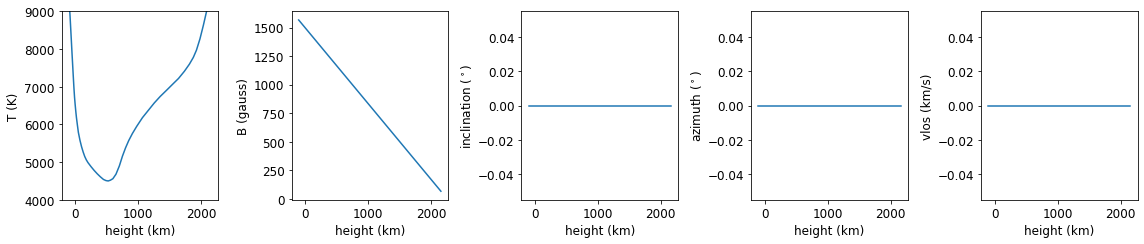

In [74]:
# Read output directory and plot the atmosphere
KM_TO_M = 1.0E3

fig, ax = plt.subplots(1,5, figsize = (16, 3.5))
ax[0].set_ylim(4000, 9000)
ax[0].set_ylabel('T (K)')
ax[1].set_ylabel('B (gauss)')
ax[2].set_ylabel(r'inclination ($^\circ$)')
ax[3].set_ylabel(r'azimuth ($^\circ$)')
ax[4].set_ylabel('vlos (km/s)')
for jj in range(5):
    ax[jj].set_xlabel('height (km)')


# Read the input atmospheres from RH's output directory
falc = rhanalyze.rhout(rhoutput) 
height = falc.geometry.height/ KM_TO_M
tau500 = falc.geometry.tau500

# Plot the Temperature and magnetic field vector as a function of height
ax[0].plot(height, falc.atmos.T)
ax[1].plot(height, falc.atmos.B*10**4)
ax[2].plot(height, falc.atmos.gamma_B*180./np.pi)
ax[3].plot(height, falc.atmos.chi_B*180./np.pi)
ax[4].plot(height, falc.geometry.vz)

plt.tight_layout()

Stokes spectra for mu angle =  1.0


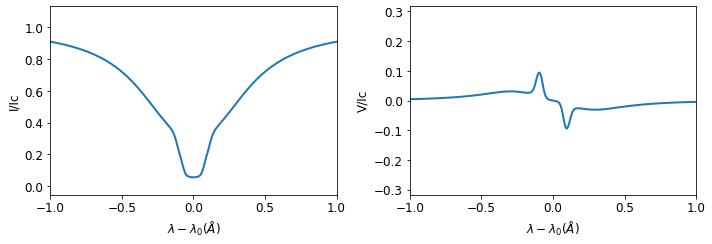

In [75]:
# Read the output directory and plot the Stokes I and V spectra


falc = rhanalyze.rhout(rhoutput) 
lam = falc.spectrum.waves*10.


# Find wavelenght index for continuum wavelength
idx_cont = (np.abs(lam - wl_cont)).argmin()

# Read the Stokes I and Stokes V arrays and divide by local continuum
I = falc.rays[0].I
print('Stokes spectra for mu angle = ',falc.rays[0].muz)
Icont = I[idx_cont]
I = I/Icont
V = falc.rays[0].V / Icont  

### FIGURE
fig, ax = plt.subplots(1,2, figsize = (10, 3.5))
ax[0].set_ylabel('I/Ic')
ax[1].set_ylabel('V/Ic')
for jj in range(2):
    ax[jj].set_xlabel(r'$\lambda -\lambda_0 (\AA)$')
    ax[jj].set_xlim(-1, 1)
    ax[jj].locator_params(axis="x", nbins=4)

# Plot the Stokes I and Stokes V as a function of wavelength
ax[0].plot(lam-lam0, I, linewidth=2.0)
ax[1].plot(lam-lam0, V, linewidth=2.0)  

plt.tight_layout()

<h2>Apply the WFA for $B_{LOS}$</h2>

First we will apply the WFA on the entire spectral line

    Bfit = [1033.53493996] Gauss, with intercept = [4.07149754e-05]


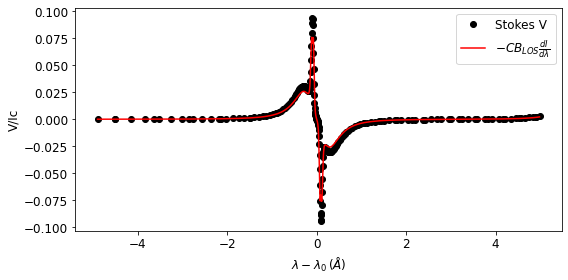

In [76]:
# Select wide range around line center
wl1 = lam0-5 #8537.1
wl2 = lam0+5 #8547.1


# derivative of I with respect to wavelength. 
# We do it over the entire wavelength grid and then cut out the spectral line 
# to avoid edge-effects from the derivative
dIdlam = np.gradient(I, lam)

# Cut out wavelength range around Ca II 8542
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))  
Vline = V[indlam]
dIdlam_line = np.squeeze(dIdlam[indlam])
lam_line = lam[indlam]

    
# Calculate Blos
# Perform a linear fit of Stokes V to -C*dI/dlam to obtain Blos

Bfit = P.polyfit(-C*dIdlam_line, Vline, 1)
print('    Bfit = ' +str(Bfit[1]) + ' Gauss, with intercept = '+str(Bfit[0]))
  
    
# FIGURE: plot Stokes V and overplot dI/dlam scaled with C and Blos

fig, ax = plt.subplots(figsize = (8, 4))

ax.plot(lam_line-lam0, Vline, 'ko', label='Stokes V')
ax.plot(lam_line-lam0, -Bfit[1]*C*dIdlam_line, 'r-', label=r'$-C B_{LOS} \frac{dI}{d\lambda}$') 
#ax.set_title('B = '+str(Bvalue)+' G')
ax.set_xlabel(r'$\lambda - \lambda_0\, (\AA) $')
ax.set_ylabel('V/Ic')

ax.legend()
plt.tight_layout()

<h2>Apply the WFA for $B_{LOS}$ in the LINE CORE</h2>

Now we will apply the WFA on two separate spectral ranges, first, the CORE of the line

In [77]:
# First we need to find the core of the spectral line. 
# If there is a non-zerovelocity, the core will not be at lambda0

# Select wide range around line center and find corresponding wavelength indices
wl1 = lam0 - 5 #8537.1
wl2 = lam0 + 5 #8547.1
newind = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))

# Find the minimum of Stokes I with your preferred method. 
# I'm just going to find the index of the lowest intensity value
Icutout = I[newind].squeeze()
minI = np.argwhere(Icutout == np.min(Icutout))+newind[0]
minI = minI.squeeze()
print()
print('Intensity minimum wavelength: ' + format(lam[minI],'4.2f') + ' Ang.')
print()


Intensity minimum wavelength: 5889.95 Ang.



    Bfit = 1002.06 Gauss, with intercept = -0.00003


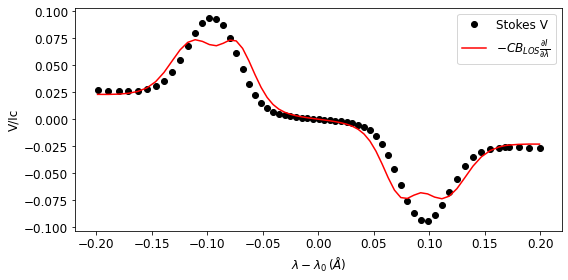

In [84]:
# line core only
wl1 = lam[minI] - 0.2
wl2 = lam[minI] + 0.2
#wl1 = 8541.8 #- 0.25
#wl2 = 8542.35 #- 0.25

# Cut out wavelength range around Ca II 8542 line core
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2)) 
Vline = V[indlam].squeeze()
dIdlam_line = np.squeeze(dIdlam[indlam])
lam_line = np.squeeze(lam[indlam])

    
# Calculate Blos
# Perform a linear fit of Stokes V to -C*dI/dlam to obtain Blos
# Check the intercept. It should be compatible with zero.

Bfit = P.polyfit(-C*dIdlam_line, Vline, 1)
Bcore = Bfit[1]
print('    Bfit = ' + format(Bcore, '4.2f') + ' Gauss, with intercept = '+format(Bfit[0],'2.5f'))


    
### FIGURE: plot Stokes V and overplot dI/dlam scaled with C and Blos
fig, ax = plt.subplots(figsize = (8, 4))

ax.plot(lam_line-lam0, Vline, 'ko', label='Stokes V')
ax.plot(lam_line-lam0, -Bfit[1]*C*dIdlam_line, 'r-', label=r'$-C B_{LOS} \frac{\partial I}{\partial \lambda}$') 
#ax.set_title('B = '+str(Bvalue)+' G')
ax.set_xlabel(r'$\lambda - \lambda_0\, (\AA) $')
ax.set_ylabel('V/Ic')
ax.legend()
plt.tight_layout()

<h2>Apply the WFA for $B_{LOS}$ in the LINE WING</h2>



    Bfit = 1258.12 Gauss, with intercept = 0.000003


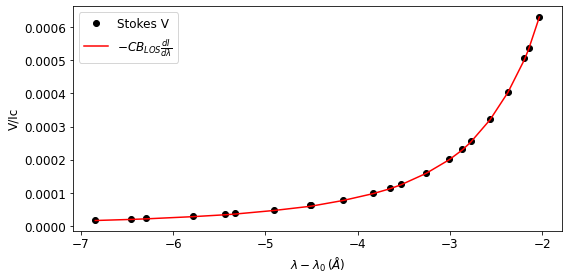

In [85]:
# line wing only
wl1 = lam[minI]- 7. 
wl2 = lam[minI]- 2. 

# Cut out wavelength range in the wing of Ca II 8542
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))  
Vline = np.squeeze(V[indlam])
dIdlam_line = np.squeeze(dIdlam[indlam])
lam_line = np.squeeze(lam[indlam])
   

# Calculate Blos
# Perform a linear fit of Stokes V to -C*dI/dlam to obtain Blos
# Check the intercept. It should be compatible with zero.

Bfit = P.polyfit(-C*dIdlam_line, Vline, 1)
Bwing = Bfit[1]
print('    Bfit = ' +format(Bfit[1], '4.2f') + ' Gauss, with intercept = '+ format(Bfit[0], '2.6f'))


#### FIGURE plot Stokes V and overplot dI/dlam scaled with C and Blos
fig, ax = plt.subplots(figsize = (8, 4))

ax.plot(lam_line-lam0, Vline, 'ko', label='Stokes V')
ax.plot(lam_line-lam0, -Bfit[1]*C*dIdlam_line, 'r-', label=r'$-C B_{LOS} \frac{dI}{d\lambda}$') 
ax.set_xlabel(r'$\lambda - \lambda_0\, (\AA) $')
ax.set_ylabel('V/Ic')
ax.legend()
plt.tight_layout()

<h1>Average heights probed by the core and the wing of the spectral line</h1>

Height[Bcore] =  751.6 km
Height[Bwing] =  351.4 km


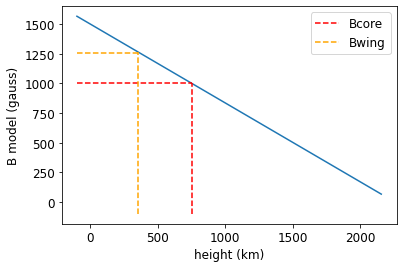

In [86]:
Bmodel = falc.atmos.B*10**4 # model magnetic field
# Get the indices and heights where the WFA inferred Bcore and Bwing intersect the model magnetic field.
indcore = np.argmin(np.abs(Bmodel-Bcore))
indwing = np.argmin(np.abs(Bmodel-Bwing))
hcore = height[indcore]
hwing = height[indwing]
print('Height[Bcore] = '+ format(hcore, '6.1f') + ' km')
print('Height[Bwing] = '+ format(hwing, '6.1f') + ' km')

# Plot model field and where WFA values intersect model 

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(height, Bmodel) # model magnetic field as a function of height
ax.plot(((height[-1], height[indcore])), ((Bcore, Bcore)),linestyle='--', label='Bcore', color = 'red')
ax.plot(((hcore,hcore)),((height[-1],Bmodel[indcore])),linestyle='--', color = 'red')
ax.plot(((height[-1], height[indwing])), ((Bwing, Bwing)),linestyle='--', label='Bwing', color = 'orange')
ax.plot(((hwing,hwing)),((height[-1],Bmodel[indwing])),linestyle='--', color = 'orange')
ax.set_ylabel('B model (gauss)')
ax.set_xlabel('height (km)')
ax.legend()

